In [1]:
import os
os.chdir("/chess/")

In [20]:
import torch
from torch import nn, optim
from torch.utils.tensorboard import SummaryWriter
import torchvision
from torchvision import transforms as T
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from chesscog import DATA_DIR

In [22]:
TRANSFORM_IMG = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
])

dataset = torchvision.datasets.ImageFolder(root=DATA_DIR / "occupancy",
                                           transform=TRANSFORM_IMG)
n_total = len(dataset)
n_val = n_test = int(.01 * n_total)
n_test = n_test = int(.1 * n_total)
n_train = n_total - n_val - n_test

print(f"{n_total} samples total, split ({n_train}/{n_val}/{n_test}) into (train/val/test))")
train_set, val_set, test_set = torch.utils.data.random_split(dataset,
                                                             (n_train, n_val, n_test),
                                                             generator=torch.Generator().manual_seed(42))

BATCH_SIZE = 128
WORKERS = 2
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE,
                                           shuffle=True, num_workers=WORKERS)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=WORKERS)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16,
                                          shuffle=False, num_workers=WORKERS)

312832 samples total, split (278421/3128/31283) into (train/val/test))


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input size: 100x100
        self.conv1 = nn.Conv2d(3, 16, 5) # 96
        self.pool1 = nn.MaxPool2d(2, 2) # 48
        self.conv2 = nn.Conv2d(16, 32, 5) # 44
        self.pool2 = nn.MaxPool2d(2, 2) # 22
        self.conv3 = nn.Conv2d(32, 64, 3) # 20
        self.pool3 = nn.MaxPool2d(2, 2) # 10
        self.fc1 = nn.Linear(64 * 10 * 10, 1000)
        self.fc2 = nn.Linear(1000, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 10 * 10)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net.to(device)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=6400, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)

In [6]:
log_every_n = 100
step = 0
writer = SummaryWriter()

for epoch in range(2):  # loop over the dataset multiple times
    
    correct = 0
    total = 0

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        step += 1

        # Get the current minibatch
        inputs, labels = (x.to(device) for x in data)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = net(inputs)
        
        # Maintain batch statistics to compute accuracy later
        with torch.no_grad():
            correct += (outputs.argmax(axis=-1) == labels).cpu().sum().item()
            total += labels.size(0)
        
        # Backward pass and optimize
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()


        if i % log_every_n == log_every_n - 1:

            # Log metrics
            writer.add_scalar("Loss/train", loss.item(), step)
            writer.add_scalar("Accuracy/train", correct / total, step)

            # Compute validation metrics
            with torch.no_grad():
                val_correct = 0
                val_total = 0
                val_running_loss = 0.
                for data in val_loader:
                    inputs, labels = data[0].to(device), data[1].to(device)
                    outputs = net(inputs)
                    loss = criterion(outputs, labels)
                    val_correct += (outputs.argmax(axis=-1) == labels).cpu().sum().numpy()
                    val_total += labels.shape[0]
                    val_running_loss += loss.item()
                writer.add_scalar("Loss/val", val_running_loss/val_total, step)
                writer.add_scalar("Accuracy/val", val_correct/val_total, step)

print('Finished Training')

epoch 1 batch 100 loss 0.668 acc 0.658 val 0.687
epoch 1 batch 200 loss 0.642 acc 0.663 val 0.687
epoch 1 batch 300 loss 0.635 acc 0.665 val 0.687
epoch 1 batch 400 loss 0.630 acc 0.665 val 0.687
epoch 1 batch 500 loss 0.618 acc 0.665 val 0.687
epoch 1 batch 600 loss 0.576 acc 0.673 val 0.785
epoch 1 batch 700 loss 0.490 acc 0.688 val 0.819
epoch 1 batch 800 loss 0.398 acc 0.705 val 0.885
epoch 1 batch 900 loss 0.337 acc 0.724 val 0.909
epoch 1 batch 1000 loss 0.262 acc 0.742 val 0.925
epoch 1 batch 1100 loss 0.206 acc 0.759 val 0.949
epoch 1 batch 1200 loss 0.178 acc 0.774 val 0.952
epoch 1 batch 1300 loss 0.145 acc 0.787 val 0.947
epoch 1 batch 1400 loss 0.124 acc 0.799 val 0.964
epoch 1 batch 1500 loss 0.105 acc 0.810 val 0.956
epoch 1 batch 1600 loss 0.106 acc 0.820 val 0.965
epoch 1 batch 1700 loss 0.095 acc 0.828 val 0.970
epoch 1 batch 1800 loss 0.098 acc 0.836 val 0.968
epoch 1 batch 1900 loss 0.085 acc 0.843 val 0.972
epoch 1 batch 2000 loss 0.070 acc 0.849 val 0.973
epoch 1 b

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


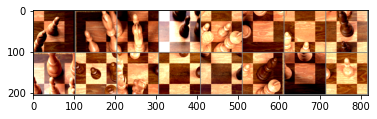

GroundTruth:  1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 1


In [30]:
def imshow(img):
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show()

    
dataiter = iter(test_loader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join(str(l.item()) for l in labels))

In [36]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = (x.to(device) for x in data)
        outputs = net(images)
        predicted = outputs.argmax(axis=-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 98 %


In [41]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
with torch.no_grad():
    for data in test_loader:
        images, labels = (x.to(device) for x in data)
        outputs = net(images)
        predicted = outputs.argmax(axis=-1)
        c = (predicted == labels).squeeze()
        for i, label in enumerate(labels):
            class_correct[label] += c[i].item()
            class_total[label] += 1

Accuracy of     0 : 000098 %
Accuracy of     1 : 000098 %


In [42]:
for i in range(2):
    print('Accuracy of %5s : %.3f %%' % (
        str(i), 100 * class_correct[i] / class_total[i]))

Accuracy of     0 : 98.506 %
Accuracy of     1 : 98.798 %


In [43]:
class_correct

[20573.0, 10273.0]